# Step 0. Import libraries

In [1]:
import os
import numpy as np
import tarfile
import sys
from scipy import ndimage
import cv2
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# Step 1. Uncompress files

In [2]:
num_classes = 3
train_filename = 'training-images.tar.gz'
test_filename = 'test-images.tar.gz'

def do_extract(filename, force=False):
    # remove .tar.gz
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  
    # check whether the uncompressed file already exists
    if os.path.isdir(root) and not force:
        print('%s already exists. Skipping extracting %s.' % (root, filename))
    else:
        print('Extracting data for %s...' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (num_classes, len(data_folders)))
    print(data_folders)
    return data_folders

train_folders = do_extract(train_filename)
#test_folders = do_extract(test_filename)

training-images already exists. Skipping extracting training-images.tar.gz.
['training-images/couches', 'training-images/mattresses', 'training-images/tv-monitor']


# Step 2. Create the dataset 

In [3]:
# image width and height
image_width = 500 
image_height = 375

def do_load(folder, min_num_images):
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_height, image_width, 3), dtype=np.float32)
    num_images = 0
    for image in image_files[3:]:
        image_file = os.path.join(folder, image)
        try:
            image_data = cv2.imread(image_file)
            # image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
            if image_data.shape != (image_height, image_width, 3):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :, :] = image_data
            num_images += 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0: num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Fewer images than expected: %d < %d' %(num_images, min_num_images))

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

# Step 3. Pickle the dataset

In [4]:
def do_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        pickle_filename = folder + '.pickle'
        dataset_names.append(pickle_filename)
        if os.path.exists(pickle_filename) and not force:
            print('%s already exists. Skippped pickling.' % pickle_filename)
        else:
            print('Pickling %s...' % pickle_filename)
            dataset = do_load(folder, min_num_images_per_class)
            try:
                with open(pickle_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', pickle_filename, ':', e)
    return dataset_names

In [5]:
train_datasets = do_pickle(train_folders, 3)
#test_datasets = do_pickle(test_folders, 1800)

Pickling training-images/couches.pickle...
Full dataset tensor: (26, 375, 500, 3)
Mean: 119.155
Standard deviation: 64.5371
Pickling training-images/mattresses.pickle...
Full dataset tensor: (21, 375, 500, 3)
Mean: 105.046
Standard deviation: 64.2476
Pickling training-images/tv-monitor.pickle...
Full dataset tensor: (9, 375, 500, 3)
Mean: 109.098
Standard deviation: 74.2508


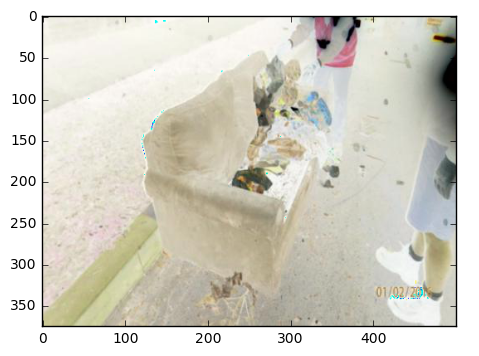

In [6]:
train_path = 'training-images/couches.pickle'
with open(train_path, 'rb') as f:
    train = pickle.load(f)
train.shape
img = train[0]
plt.imshow(img)

In [28]:
def create_dataset(batch_size, image_height, image_width):
    features = np.ndarray(shape=(batch_size, image_height, image_width, 3), dtype=np.float32)
    labels = np.ndarray(batch_size, dtype=np.int32)
    return features, labels

def merge_datasets(pickle_files, train_size):
    num_classes = len(pickle_files)
    train_size_per_class = train_size // num_classes
    train_dataset, train_labels = create_dataset(train_size, image_height, image_width)
    train_offset = 0
    
    for label, pickle_file in enumerate(pickle_files):  
        try:
            with open(pickle_file, 'rb') as f:
                item_set = pickle.load(f)
                np.random.shuffle(item_set)
                train_item = item_set[:train_size_per_class, :, :]
                train_dataset[train_offset:train_offset+train_size_per_class, :, :] = train_item
                train_labels[train_offset:train_offset+train_size_per_class] = label
                train_offset += train_size_per_class
        
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            
    return train_dataset, train_labels

In [32]:
train_size = 10
#test_size = 10000

train_dataset, train_labels = merge_datasets(train_datasets, train_size)
#_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
# print('Testing:', test_dataset.shape, test_labels.shape)

Training: (10, 375, 500, 3) (10,)


0

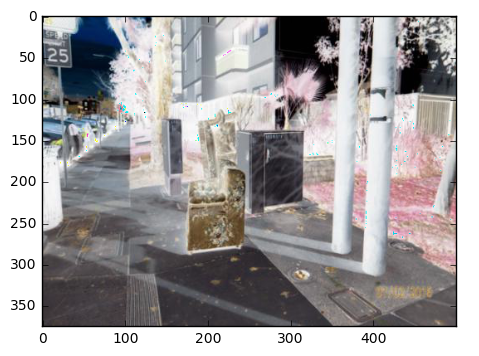

In [44]:
img = train_dataset[2]
plt.imshow(img)
train_labels[2]

Credits: 
<ul>
<li>https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/1_notmnist.ipynb</li>
</ul>